In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

C:\Users\fabio\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
annotated_df = pd.read_csv("data/annotated_dataset/annotated_texts_repr.csv", sep=",", encoding="utf-8")
meta_df = pd.read_csv("data/cleaned_dataset/meta.tsv", sep=",", encoding="utf-8")

In [3]:
merged_df = annotated_df.merge(meta_df, how='left', left_on='id', right_on="ID")

In [4]:
merged_df.head(1)

,id,text,pop_sum,manichean,peoplecentrism,antielitism,emotional,polarization,tfidf,doc_embedding,...,Term,Subcorpus,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_gender,Speaker_birth
0,ParlaMint-IT_2013-08-01-LEG17-Senato-sed-86.u153,"PETROCELLI . Signor Presidente, senatrici e se...",4,1,1,1,1,1,"[0.5361957907801886, 0.049413195954373046, 0.0...","[0.009776607354980394, 0.04375904489842546, -0...",...,17 Legislatura,Reference,notMinister,M5S.1,Movimento 5 Stelle,Opposition,Pigliatutto,PetrocelliVitoRosario,M,1964


In [16]:
ling_prof_df = merged_df[["id", "Speaker_ID", "Speaker_party","Party_orientation","linguistic_profile", "tfidf", "doc_embedding"]]
diz = {
    "LN-Aut": "Lega",
    "L-SP": "Lega",
    "M5S.1": "M5S",
    "M5S.2": "M5S",
}
ling_prof_df = ling_prof_df.replace({"Speaker_party": diz})

In [21]:
def mean_lists(lists):
    lists = np.array([ast.literal_eval(item) for item in lists])
    return np.mean(lists, axis=0).tolist()

df_grouped = ling_prof_df.groupby('Speaker_ID', as_index=False).agg({
    'linguistic_profile': lambda x: mean_lists(list(x)),
    'tfidf': lambda x: mean_lists(list(x)),
    'doc_embedding': lambda x: mean_lists(list(x)),
    'Speaker_party': lambda x: x.mode()[0],
    'Party_orientation': lambda x: x.mode()[0]
})

In [22]:
df_grouped.head(3)

,Speaker_ID,linguistic_profile,tfidf,doc_embedding,Speaker_party,Party_orientation
0,AbateRosaSilvana,"[32.5, 1156.8333333333333, 36.00833140774001, ...","[0.473496964052131, 0.12630132358189117, 0.056...","[0.029611254304471205, 0.03501105125431001, 0....",M5S,Pigliatutto
1,AccotoRossella,"[39.0, 1344.3, 36.43176716161459, 4.8736742056...","[0.5622668268003259, 0.14021344694754465, 0.11...","[0.01827499188860922, 0.039333732658723766, -0...",M5S,Pigliatutto
2,AielloPiero,"[48.07142857142857, 1561.7857142857142, 33.948...","[0.51194343450785, 0.054437494833317786, -0.04...","[0.021812152499411677, 0.05375205107063192, -0...",NCD,Centro verso centro-destra


In [9]:
df_grouped["Speaker_party"].value_counts()

Speaker_party
PD       148
M5S      129
Lega      67
PdL       53
FI-BP     48
NCD       25
FdI       22
SCpI      15
Name: count, dtype: int64

In [23]:
df_grouped["Party_orientation"].value_counts()

Party_orientation
Centro-sinistra                148
Pigliatutto                    129
Centro-destra                  101
Destra verso estrema destra     89
Centro verso centro-destra      25
Centro                          15
Name: count, dtype: int64

### Linguistic Profile Mean

In [26]:
def clustering(df, column, guess_column):
    X = np.vstack(df[column].values)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    num_clusters = df[guess_column].nunique() #k=8
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    ari_score = adjusted_rand_score(df[guess_column], df['Cluster'])
    nmi_score = normalized_mutual_info_score(df[guess_column], df['Cluster'])

    print(f"Adjusted Rand Index: {ari_score:.2f}")
    print(f"Normalized Mutual Information Score: {nmi_score:.2f}")

    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X_scaled)

    df['PC1'] = X_2D[:, 0]
    df['PC2'] = X_2D[:, 1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.scatterplot(ax=axes[0], x='PC1', y='PC2', hue=df[guess_column], palette='Set1', data=df, s=100, alpha=0.7)
    axes[0].set_title("True Labels")

    sns.scatterplot(ax=axes[1], x='PC1', y='PC2', hue=df['Cluster'], palette='Set2', data=df, s=100, alpha=0.7)
    axes[1].set_title("K-Means Clusters")

    plt.show()

Adjusted Rand Index: 0.02
Normalized Mutual Information Score: 0.07


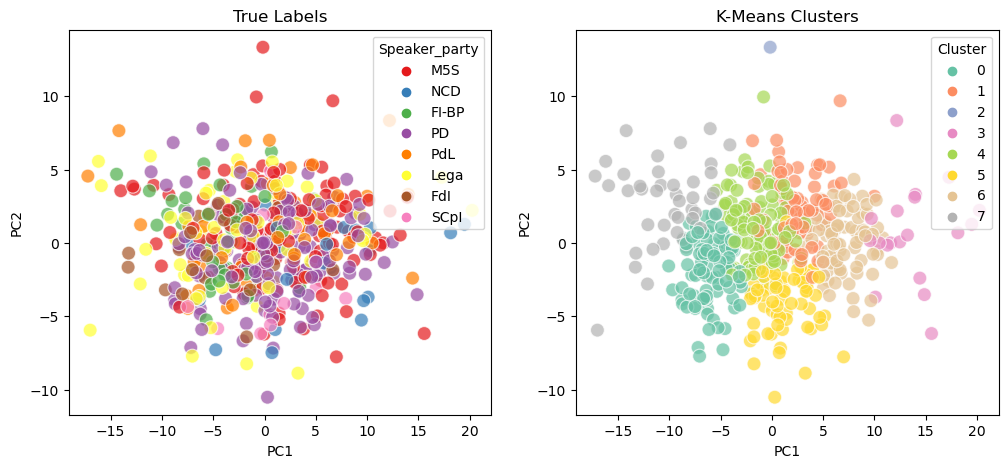

In [27]:
clustering(df_grouped,'linguistic_profile', 'Speaker_party')

Adjusted Rand Index: 0.03
Normalized Mutual Information Score: 0.06


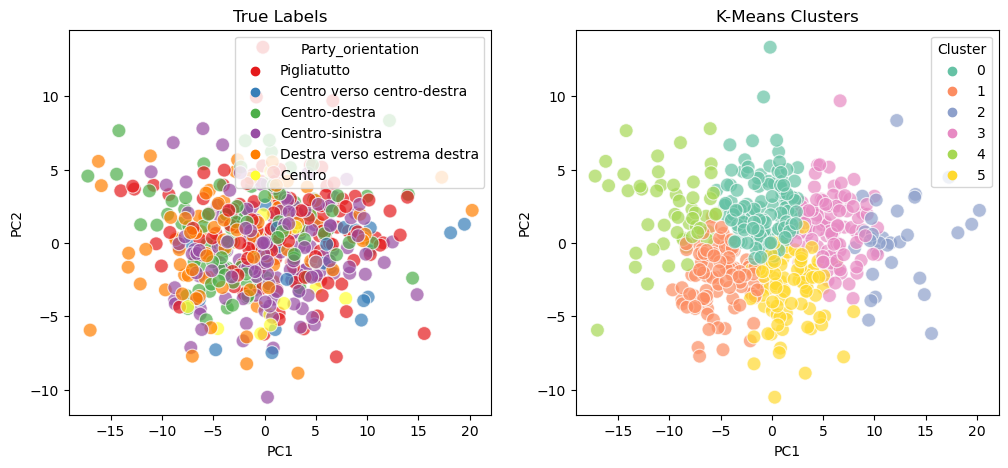

In [25]:
clustering(df_grouped,'linguistic_profile', 'Party_orientation')

##### solo PD e M5S

In [12]:
df_grouped_limited = df_grouped[df_grouped["Speaker_party"].isin(["PD", "M5S"])]

Adjusted Rand Index: -0.00
Normalized Mutual Information Score: 0.00


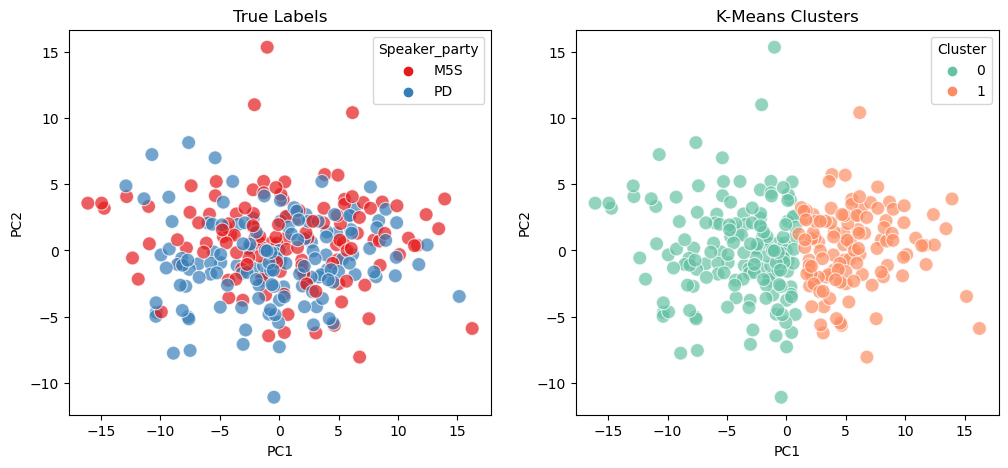

In [28]:
clustering(df_grouped_limited, 'linguistic_profile', 'Speaker_party')

### TFIDF

Adjusted Rand Index: 0.05
Normalized Mutual Information Score: 0.08


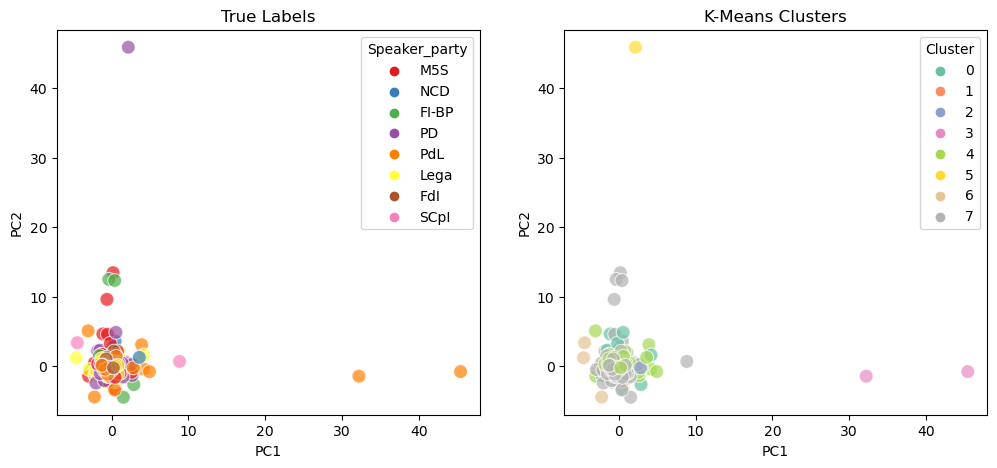

In [14]:
clustering(df_grouped,'tfidf')

## Doc Embedding

Adjusted Rand Index: 0.02
Normalized Mutual Information Score: 0.08


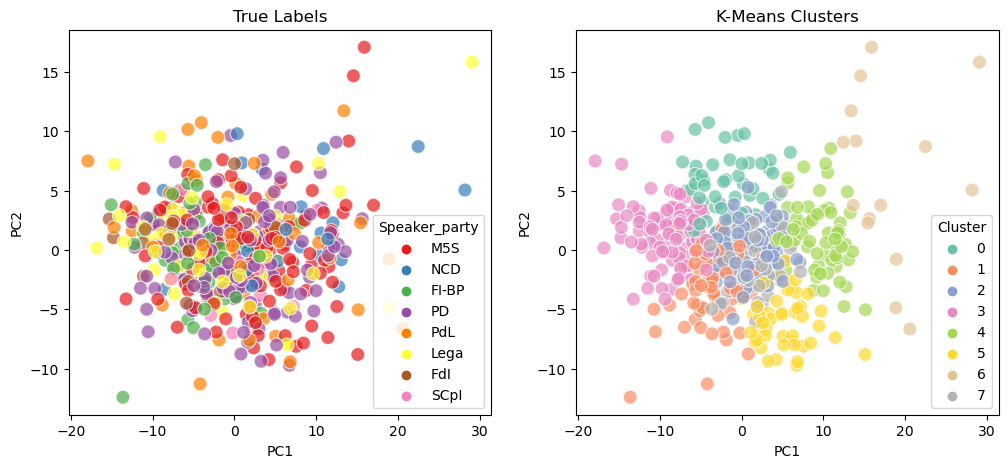

In [29]:
clustering(df_grouped,'doc_embedding', 'Speaker_party')

Adjusted Rand Index: 0.03
Normalized Mutual Information Score: 0.05


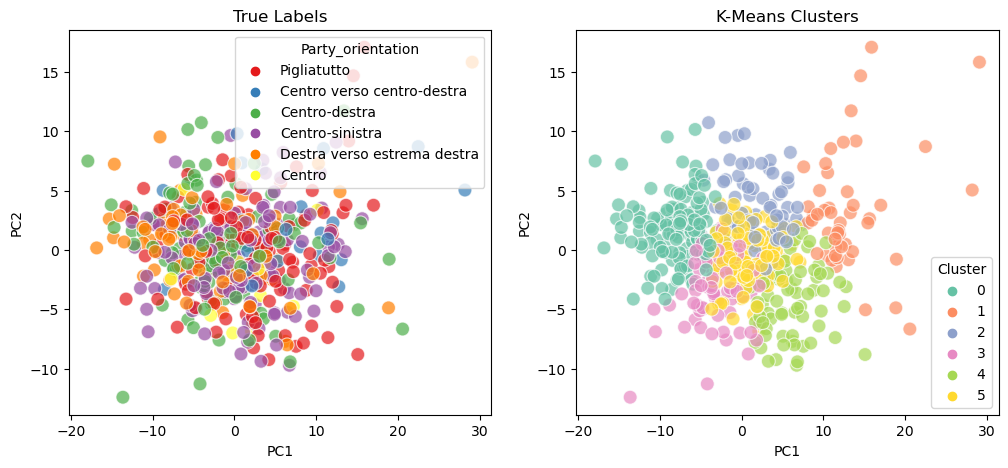

In [30]:
clustering(df_grouped,'doc_embedding', 'Party_orientation')